## B0 calculations 
This will be (for now, maybe forever) a test script for the calculations and analysis of B0 fields

In [271]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import math

In [273]:
def read_csv_numpy(filename):
    data = np.loadtxt(filename, delimiter=',', skiprows=1)  # skiprows=1 if there's a header
    print(f"Data shape: {data.shape}")
    return data

#The function used for calculating the allan variance is based on:
#https://liquidinstruments.com/application-notes/understanding-and-performing-allan-variance-measurements/
def allan(y,t,n):
    tau_0 = (t[2]-t[1])*n
    K = len(y)
    truncated_length = (len(y) // n) * n
    y_truncated = y[:truncated_length]
    y_M = y_truncated.reshape(-1, n).mean(axis=1) #include overlapping algorythm, for n=1 every data point sampled
    N = math.log2(len(y_M))
    N = math.floor(N)
    sigma_y_sq = np.zeros(N)
    for i in range(0,N-1):
        m = i+1
        truncated_length = (len(y_M) // m) * m
        y = y_M[:truncated_length]
        y = y.reshape(-1, m).mean(axis=1) 
        K = len(y)
        for j in range (0,K-2):
            sigma_y_sq[i] = sigma_y_sq[i]+(y[j+1]-y[j])**2
            
        sigma_y_sq[i] = 1/(2*(K-1))*sigma_y_sq[i]
    sigma_y = np.sqrt(sigma_y_sq)
    return sigma_y, tau_0

def gaussian(x,A,x0,s):
    return A*np.exp(-(x-x0)**2/s**2)

In [213]:
louis = read_csv_numpy("C:/Users/ledel/QuantumHardwareLab/B0field/Data/raw/earth_room_louis.csv")
sri = read_csv_numpy("C:/Users/ledel/QuantumHardwareLab/B0field/Data/raw/earth_room_sri.csv")
ben = read_csv_numpy("C:/Users/ledel/QuantumHardwareLab/B0field/Data/raw/earth_room_ben.csv")
print(ben[0,0])
# [time, x, y, z, absolute]

Data shape: (499, 5)
Data shape: (1003, 5)
Data shape: (1003, 5)
0.01004487497


Here I want to now compare the different data sets. First, I want to simply look at a histogram and calculate a gaussian to compare a the statistical models with each other. I will assume a normal distribution for now, depending on the allan deviation this might be proven or disproven!
Then we can turn to the allan deviation, this could help us understand the different statistic or systematic noise components
TODO: 
* this could be used to find a model and/or compare with other measurements
* can we find a correlation between these 3 devices

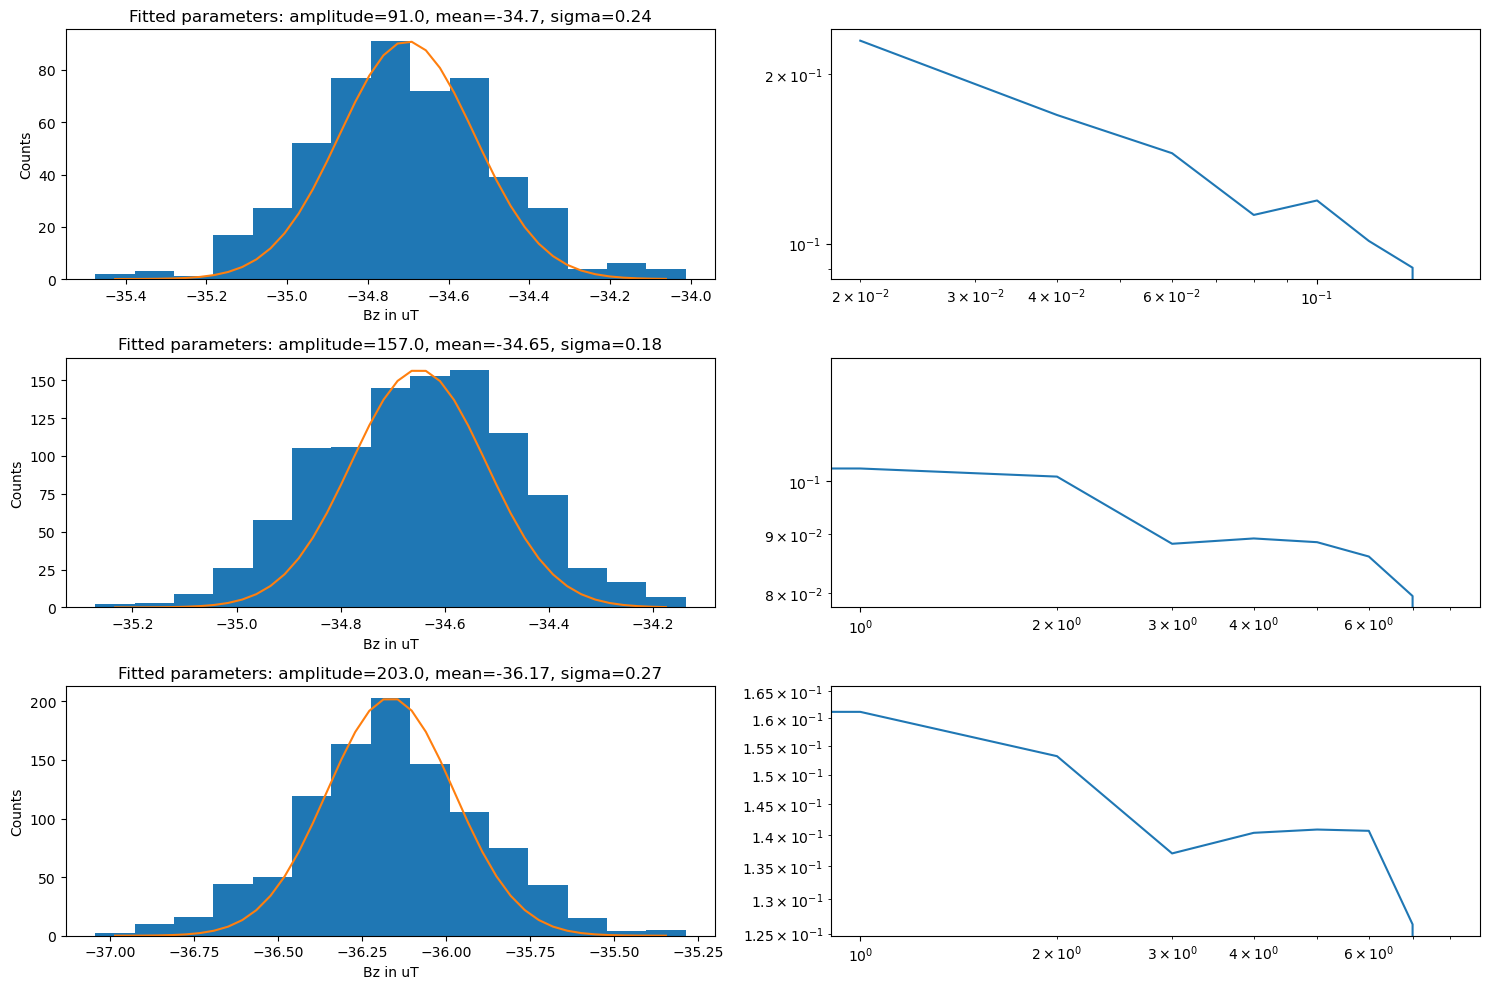

In [275]:
fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3, 2, figsize=(15, 10))

counts_l, bin_edges, patches = ax1.hist(louis[:,3],bins=15)
bins_l = (bin_edges[:-1] + bin_edges[1:]) / 2
#popt, pcov = curve_fit(gaussian, bins_l, counts_l, p0=[max(counts_l), np.mean(louis[:,3]), np.std(louis[:,3])])
#ax1.hist(louis[:,3], bins=50, label='Histogram')
#ax1.plot(bins_l, gaussian(bins_l, *popt), 'r-', linewidth=2, label='Fit')
range_l = np.linspace(bins_l[0],bins_l[14],40)
ax1.plot(range_l,gaussian(range_l,max(counts_l), np.mean(louis[:,3]), np.std(louis[:,3])))
ax1.set_title(f"Fitted parameters: amplitude={max(counts_l)}, mean={round(np.mean(louis[:,3]),2)}, sigma={round(np.std(louis[:,3]),2)}")
ax1.set_ylabel('Counts')
ax1.set_xlabel('Bz in uT')

allan_l,tau_l = allan(louis[:,3],louis[:,0],1)
tl = np.linspace(1,len(allan_l),len(allan_l))*tau_l
ax4.plot(tl,allan_l)
ax4.set_yscale('log')
ax4.set_xscale('log')

counts_b, bin_edges, patches = ax2.hist(ben[:,3],bins=15)
bins_b = (bin_edges[:-1] + bin_edges[1:]) / 2
range_b = np.linspace(bins_b[0],bins_b[14],40)
ax2.plot(range_b,gaussian(range_b,max(counts_b), np.mean(ben[:,3]), np.std(ben[:,3])))
ax2.set_title(f"Fitted parameters: amplitude={max(counts_b)}, mean={round(np.mean(ben[:,3]),2)}, sigma={round(np.std(ben[:,3]),2)}")
ax2.set_ylabel('Counts')
ax2.set_xlabel('Bz in uT')

allan_b, tau_b = allan(ben[:,3],ben[:,0],1)
tb = np.linspace(1,len(allan_b),len(allan_b))*tau_b
ax5.plot(allan_b)
ax5.set_yscale('log')
ax5.set_xscale('log')

counts_s, bin_edges, patches = ax3.hist(sri[:,3],bins=15)
bins_s = (bin_edges[:-1] + bin_edges[1:]) / 2
range_s = np.linspace(bins_s[0],bins_s[14],40)
ax3.plot(range_s,gaussian(range_s,max(counts_s), np.mean(sri[:,3]), np.std(sri[:,3])))
ax3.set_title(f"Fitted parameters: amplitude={max(counts_s)}, mean={round(np.mean(sri[:,3]),2)}, sigma={round(np.std(sri[:,3]),2)}")
ax3.set_ylabel('Counts')
ax3.set_xlabel('Bz in uT')

allan_s, tau_s = allan(sri[:,3],sri[:,0],1)
ts = np.linspace(1,len(allan_s),len(allan_s))*tau_s
ax6.plot(allan_s)
ax6.set_yscale('log')
ax6.set_xscale('log')

plt.tight_layout()  # Adjusts spacing
plt.show()

[-35.47500229 -35.32875214 -35.18250198 -35.03625183 -34.89000168
 -34.74375153 -34.59750137 -34.45125122 -34.30500107 -34.15875091
 -34.01250076]
[  4.   2.  44.  52. 131. 109.  77.  66.   9.   5.]


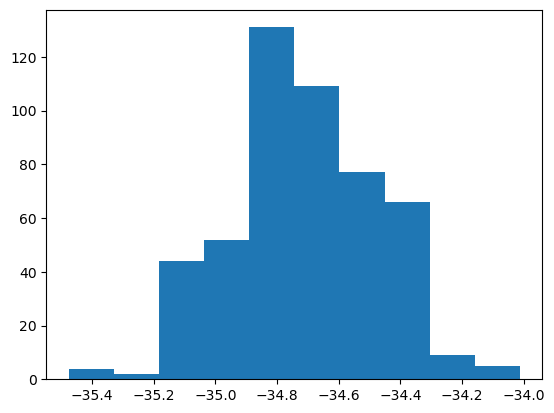

In [141]:
x=plt.hist(louis[:,3])
print(x[1])
print(x[0])